In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.utils.data as data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import time

from torchsummary import summary

from sklearn.model_selection import train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

######### SET PARAMETERS #########
bs = 4
lr = 0.1
epochs = 100
seed = 0
N=10
split = 0.2

#Reproducability
torch.manual_seed(seed)

In [14]:
#Compute mean and standard deviation of a dataset 

#METHOD 1
def dataset_mean_std(loader):
    mean = 0.0
    std = 0.0
    var = 0.0
    for image, label in loader:
        #image (10,3,56,56)
        #label (10)

        image = image.view(image.size(0), image.size(1), -1) 
        mean = mean + image.mean(2).sum(0)
        var = var + image.var(2).sum(0)

    mean = mean / len(loader.dataset)
    var = var / len(loader.dataset)
    std = torch.sqrt(var)
    
    return mean, std

#METHOD 2 (less accurate)
#data = next(iter(rawloader))
#print(data[0].mean(), data[0].std())


In [15]:
######## LOADS AND SPLITS TRAIN, VALID DATA ########
def load_data(batch_size, split): 

    full = datasets.ImageFolder(root='training_v2/',transform = transforms.ToTensor()) 
    print(full)
    full_loader = data.DataLoader(full,batch_size = len(full), shuffle=True)    
    
    #Calculate mean of full dataset 
    mean, std = dataset_mean_std(full_loader) 
    print(mean,std)

    #Normalize the full dataset
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
    
    #Define train & test datasets (just copies of the normalized full, to be split in the next lines)
    train = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans)
    test = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans) 

    #Split normalized train & test 
    idxs = list(range(len(train))) #create indices from 0 to the number of training data
    split = int(np.floor(split * len(train))) #rounded up to closest integers
    
    np.random.shuffle(idxs) #shuffle the numbers of the indices (so train and test are split randomly)

    train_idx, test_idx = idxs[split:], idxs[:split]

    train_samp = SubsetRandomSampler(train_idx) #randomly assigning samples to train/test
    test_samp = SubsetRandomSampler(test_idx)

    trainloader = data.DataLoader(train, sampler = train_samp, batch_size=batch_size)
    testloader = data.DataLoader(test, sampler = test_samp, batch_size=batch_size)

    return trainloader, testloader #randomly split data 


In [16]:
######## DEFINE CNN CLASS ########
class CNN(nn.Module): ####################################################################################
    def __init__(self):
        super(CNN, self).__init__()
        #NUMBER OF KERNELS (Pick 10,30)
        self.conv1 = nn.Conv2d(3, 10, 3) #(rgb channels, kernels, size of kernels 3x3) <-- stride = 1 by default
        self.pool = nn.MaxPool2d(2, 2) #(size 2x2, stride 2)
        self.conv1_BN = nn.BatchNorm2d(10)
        
        self.conv2 = nn.Conv2d(10, 10, 3) #(input channels = output feature map from first layer) 
        self.conv2_BN = nn.BatchNorm2d(10)
        
        self.conv3 = nn.Conv2d(10, 10, 3)
        self.conv3_BN = nn.BatchNorm2d(10)
        
        self.conv4 = nn.Conv2d(10, 10, 3)
        self.conv4_BN = nn.BatchNorm2d(10)

        
        #NUMBER OF NEURONS (Pick 8,32)
        self.fc1 = nn.Linear(10,8)  #INPUT= SIZE OF LAST POOL (-,1,2,3)
        self.fc2 = nn.Linear(8, 10) 
        
        self.fc1_BN = nn.BatchNorm1d(8)

    def forward(self, x): #x is input 
        x = F.relu(self.conv1_BN(self.conv1(x))) 
        #print("1",x.shape)
        x = self.pool(x) 
        #print("2",x.shape)

        x = F.relu(self.conv2_BN(self.conv2(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
   #####      
        x = F.relu(self.conv3_BN(self.conv3(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
        
        x = F.relu(self.conv4_BN(self.conv4(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
    #####
        x = x.view(-1, 10) #OUTPUT= SIZE OF LAST POOL (-,1 2 3) #########
        #print("5",x.shape)

        x = self.fc1_BN(self.fc1(x)) 
        #print("6",x.shape)
        x = self.fc2(x) 
        #print("7",x.shape)

        return x

In [17]:
######## INSTANTIATE MODEL, DEFINE LOSS FCN & OPTIMIZER ########
def load_model(learning_rate):
    
    model = CNN() 
    loss_fnc = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 

    return model, loss_fnc, optimizer

In [18]:
######## CALCULATES BATCHACC (in training) ########
def accuracy(predictions, labels):
    correct = 0 
    total = 0
    
    _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
    total = total + len(labels) #can probably change to just len(labels) later
    correct = correct + (predicted.float() == labels).sum() 


    batchacc = correct.item() / total
    return batchacc
    

In [19]:
######## CALCULATES VALIDATION ACC & LOSS (at end of each epoch) ########
def evaluate(model, val_loader):
    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    
    for i,data in enumerate(val_loader,0): #go through each batch in val_loader
        inputs, labels = data
        predictions = model(inputs.float()) #tensor size bs --> grad_fnc = sigmoidbackward    
        
        #Calculate accuracy 
        _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
        
        total = total + len(labels) 
        
        correct = correct + (predicted.float() == labels.float()).sum() 
        acc = correct.item() / total
        
        #Calculate loss
        loss = loss_fnc(predictions, labels.long())
        batchloss_accum = batchloss_accum + batchloss.item()
        
        
    avgbatchloss = batchloss_accum/len(train_loader)

    return acc, avgbatchloss
        


In [20]:
torch.manual_seed(seed)

#LOAD DATA 
train_loader,val_loader = load_data(bs,split) 
model,loss_fnc,optimizer = load_model(lr) #lr defined here 

#STORE FOR PLOTTING
loss_list = []
acc_list = []
nepoch = []

testacc_list = []
testloss_list = []

#Training loop 
start_time = time.time()
for e in range(epochs): 
    nepoch = nepoch + [e]

    batchloss_accum = 0.0
    batchacc_accum = 0.0

    for i, data in enumerate(train_loader, 0): #len trainloader is number of batches 
        model.train() 
        correct = 0 
        total = 0 #10-30
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #inputs = (10,3,56,56); labels = (10)

        inputs = Variable(inputs).float()
        labels = Variable(labels).float()

        # Zero parameter gradients
        optimizer.zero_grad()

        #Run model on inputs
        outputs = model(inputs) #(10,10)

        #Compute loss
        batchloss = loss_fnc(outputs, labels.long())
        batchloss.backward()
        optimizer.step()

        batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
        #print('batchloss',batchloss)

        batchacc = accuracy(outputs,labels)
        batchacc_accum = batchacc_accum + batchacc
        #print("Batch accuracy",batchacc)

        if i == len(train_loader)-1: #len(trainloader) is len(dataset) / images per batch
            model.eval() 
            vacc, vloss = evaluate(model,val_loader)
            
            print("avg acc/epoch", batchacc_accum/len(train_loader))
            print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_loader)))
            print("validation loss:", vloss)
            print("validation acc:", vacc)
            
            loss_list = loss_list + [batchloss_accum/len(train_loader)]
            acc_list = acc_list + [batchacc_accum/len(train_loader)]
            testacc_list.append(vacc)   
            testloss_list.append(vloss)

            batchloss_accum = 0.0
            batchacc_accum = 0.0 

endtime = time.time() - start_time
print('Finished Training')
print("Execution time", endtime)

Dataset ImageFolder
    Number of datapoints: 3815
    Root location: training_v2/
    StandardTransform
Transform: ToTensor()
tensor([0.6876, 0.6190, 0.5674]) tensor([0.1352, 0.1674, 0.1785])
avg acc/epoch 0.3794233289646134
[1,   763] avg loss/epoch: 1.767
validation loss: 0.33920970234927156
validation acc: 0.6002621231979031
avg acc/epoch 0.5242463958060288
[2,   763] avg loss/epoch: 1.401
validation loss: 0.4484076738982494
validation acc: 0.5897771952817824
avg acc/epoch 0.5855176933158585
[3,   763] avg loss/epoch: 1.254
validation loss: 0.20405393627961685
validation acc: 0.7680209698558322
avg acc/epoch 0.5982961992136304
[4,   763] avg loss/epoch: 1.199
validation loss: 0.4044077799485833
validation acc: 0.7024901703800787
avg acc/epoch 0.5979685452162516
[5,   763] avg loss/epoch: 1.212
validation loss: 0.3226183715372848
validation acc: 0.7418086500655308
avg acc/epoch 0.6530144167758847
[6,   763] avg loss/epoch: 1.093
validation loss: 0.23237349712051852
validation acc: 0

avg acc/epoch 0.7762123197903015
[59,   763] avg loss/epoch: 0.729
validation loss: 0.19612578241103287
validation acc: 0.8689384010484927
avg acc/epoch 0.7889908256880734
[60,   763] avg loss/epoch: 0.681
validation loss: 0.014535461036124674
validation acc: 0.8584534731323722
avg acc/epoch 0.7857142857142857
[61,   763] avg loss/epoch: 0.702
validation loss: 0.17768370402124886
validation acc: 0.8440366972477065
avg acc/epoch 0.7896461336828309
[62,   763] avg loss/epoch: 0.684
validation loss: 0.14384104055627145
validation acc: 0.8663171690694627
avg acc/epoch 0.7916120576671035
[63,   763] avg loss/epoch: 0.678
validation loss: 0.276665478515125
validation acc: 0.8689384010484927
avg acc/epoch 0.8112712975098296
[64,   763] avg loss/epoch: 0.615
validation loss: 0.07323812172890959
validation acc: 0.8610747051114024
avg acc/epoch 0.7886631716906947
[65,   763] avg loss/epoch: 0.692
validation loss: 0.12662181723008462
validation acc: 0.8676277850589778
avg acc/epoch 0.781782437745

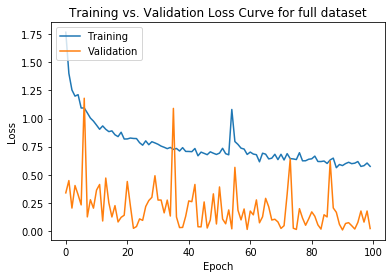

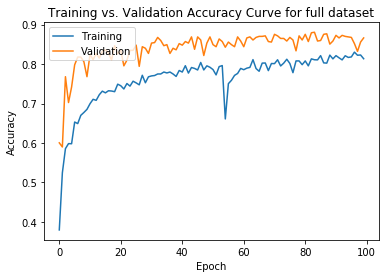

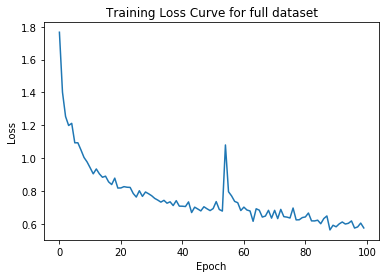

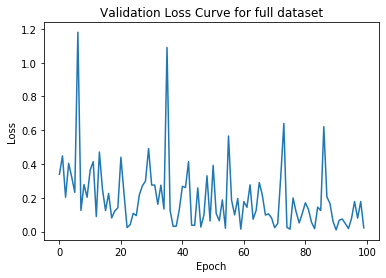

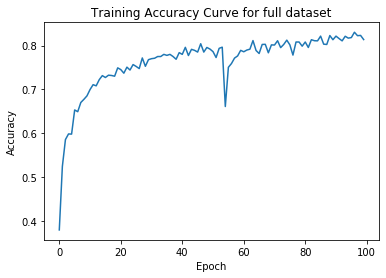

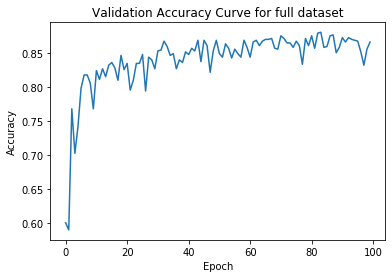

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_BN): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2_BN): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3_BN): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4_BN): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=10, bias=True)
  (fc1_BN): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
#LOSS TOGETHER
plt.plot(nepoch,loss_list, label = 'Train')
plt.plot(nepoch,testloss_list, label = 'Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training vs. Validation Loss Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#ACCURACIES TOGETHER
plt.plot(nepoch,acc_list, label = 'Train')
plt.plot(nepoch,testacc_list, label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training vs. Validation Accuracy Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#TRAIN LOSS 
plt.plot(nepoch,loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training Loss Curve for full dataset")
plt.show() 

#VALID LOSS
plt.plot(nepoch,testloss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Validation Loss Curve for full dataset")
plt.show() 

#TRAIN ACC
plt.plot(nepoch,acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training Accuracy Curve for full dataset")
plt.show() 


#VALID ACC
plt.plot(nepoch,testacc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Validation Accuracy Curve for full dataset")
plt.show()


#summary(model, input_size=(3, 56, 56))
torch.save(model.state_dict(),'MyBestSmall/MyBestSmall.pt') 

Model = CNN()

Model.load_state_dict(torch.load('MyBestSmall/MyBestSmall.pt'))

torch.save(Model,'MyBestSmall/fullsmallestbestmodel.pt2')  
model.eval()